In [319]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os 
import zipfile
from tqdm import tqdm
from glob import glob
from shutil import copy, move

## Data Preparation

In [320]:
zipfile_dir = '../input/dogs-vs-cats/train.zip'
train_dir = zipfile.ZipFile(zipfile_dir, 'r')
train_dir.extractall()



In [321]:
TRAIN_DIR = './train'


train_set = os.listdir(TRAIN_DIR)


print('#train images: %s'%len(train_set))

print(train_set[:5])


#train images: 25000
['cat.3633.jpg', 'dog.5024.jpg', 'dog.7742.jpg', 'dog.10077.jpg', 'cat.2231.jpg']


In [322]:
dog_train_dir = './training/dog'
dog_val_dir = './validation/dog'
cat_train_dir = './training/cat'
cat_val_dir = './validation/cat'
test_dir='./testing/test'

file_dirs = [dog_train_dir, dog_val_dir, cat_train_dir, cat_val_dir, test_dir]

for dir in file_dirs:
    os.makedirs(dir,exist_ok = True)

In [323]:
all_dogs = glob('./train/dog*jpg')
all_cats = glob('./train/cat*jpg')

print(len(all_dogs))
print(len(all_cats))

12500
12500


In [324]:
from sklearn.model_selection import train_test_split

dogs_train, tmp_dog_test = train_test_split(all_dogs, test_size=0.4, shuffle=True,random_state = 100)
test2, dogs_test = train_test_split(tmp_dog_test, test_size=0.5, shuffle=True,random_state = 100)

cats_train,tmp_cat_test = train_test_split(all_cats, test_size=0.4, shuffle=True,random_state = 100)
test3, cats_test = train_test_split(tmp_cat_test, test_size=0.5, shuffle=True,random_state = 100)

test=test2+test3

In [325]:
for name in tqdm(dogs_train):
  copy(name , os.path.join(dog_train_dir , name.split('/')[-1]))
for name in tqdm(cats_train):
  copy(name , os.path.join(cat_train_dir , name.split('/')[-1]))
  
for name in tqdm(dogs_test):
  copy(name , os.path.join(dog_val_dir , name.split('/')[-1]))
for name in tqdm(cats_test):
  copy(name , os.path.join(cat_val_dir , name.split('/')[-1]))
for name in tqdm(test):
  copy(name , os.path.join(test_dir , name.split('/')[-1]))

100%|██████████| 5000/5000 [00:00<00:00, 5666.56it/s]


In [326]:
print(len(os.listdir(dog_train_dir)))
print(len(os.listdir(cat_train_dir)))
print(len(os.listdir(dog_val_dir)))
print(len(os.listdir(cat_val_dir)))

11250
11250
3107
3107


## Data Preprocessing

In [327]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = './training'
train_datagen = ImageDataGenerator(rescale=1 / 255)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size=64,
    class_mode='binary',
    target_size=(150, 150)
)

VALIDATION_DIR = './validation'
validation_datagen = ImageDataGenerator(rescale=1/255)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size = 64,
    class_mode = 'binary',
    target_size = (150, 150)
)

Found 22500 images belonging to 2 classes.
Found 6214 images belonging to 2 classes.


## Model Creation

In [328]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Flatten, Dropout

model = Sequential()
model.add(Conv2D(64, (3,3), strides=(1,1), padding='same', activation='relu',kernel_initializer='he_normal',input_shape=(150, 150, 3)))
model.add(Conv2D(64, (3,3), strides=(1,1), padding='same', activation='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), strides=(1,1), padding='same', activation='relu',kernel_initializer='he_normal'))
model.add(Conv2D(128, (3,3), strides=(1,1), padding='same', activation='relu',kernel_initializer='he_normal'))
model.add(Conv2D(128, (3,3), strides=(1,1), padding='same', activation='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

In [329]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_82 (Conv2D)           (None, 150, 150, 64)      1792      
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 75, 75, 64)        0         
_________________________________________________________________
dropout_84 (Dropout)         (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 75, 75, 128)       73856     
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 75, 75, 128)       147584    
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 75, 75, 128)     

In [330]:
check_point_path = './best.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = check_point_path,
    monitor = 'val_accuracy',
    save_weights_only=False,
    save_best_only=True,
    verbose=1
)

In [331]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.0005,decay=1e-5),
             loss = 'binary_crossentropy',
             metrics = ['acc'])

In [332]:
print('Num Params : ',model.count_params())
model_history = model.fit(
    train_generator,
    epochs=20,
    verbose=1,
    callbacks = [model_checkpoint],
    validation_data=validation_generator
)

Num Params :  45399233
Epoch 1/20
352/352 [==============================] - 98s 276ms/step - loss: 1.2595 - acc: 0.5224 - val_loss: 0.6886 - val_acc: 0.5418
Epoch 2/20
352/352 [==============================] - 97s 275ms/step - loss: 0.6535 - acc: 0.6078 - val_loss: 0.5496 - val_acc: 0.7147
Epoch 3/20
352/352 [==============================] - 97s 275ms/step - loss: 0.5257 - acc: 0.7423 - val_loss: 0.4339 - val_acc: 0.7974
Epoch 4/20
352/352 [==============================] - 97s 275ms/step - loss: 0.4302 - acc: 0.7997 - val_loss: 0.4023 - val_acc: 0.8225
Epoch 5/20
352/352 [==============================] - 97s 276ms/step - loss: 0.3369 - acc: 0.8534 - val_loss: 0.2809 - val_acc: 0.8901
Epoch 6/20
352/352 [==============================] - 97s 275ms/step - loss: 0.2230 - acc: 0.9094 - val_loss: 0.2602 - val_acc: 0.9042
Epoch 7/20
352/352 [==============================] - 97s 274ms/step - loss: 0.1309 - acc: 0.9500 - val_loss: 0.2658 - val_acc: 0.9158
Epoch 8/20
352/352 [============

## Model Evaluation

Plotting Loss and Accuracy

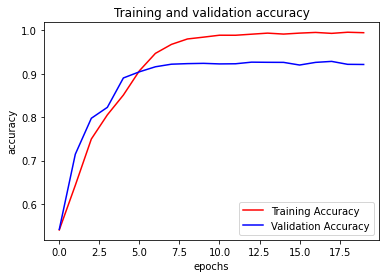

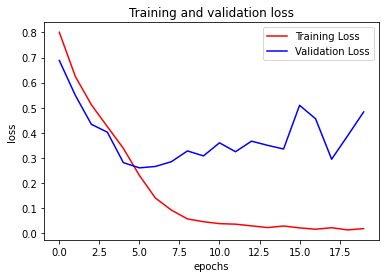

In [333]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=model_history.history['acc']
val_acc=model_history.history['val_acc']
loss=model_history.history['loss']
val_loss=model_history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(["Training Accuracy","Validation Accuracy"])
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(["Training Loss","Validation Loss"])
plt.show()

# Desired output. Charts with training and validation metrics. 

In [334]:
test_file = os.listdir("./testing/test")
test_df = pd.DataFrame({
    'filename': test_file
})
test_df

,filename
0,cat.3633.jpg
1,dog.5024.jpg
2,dog.7742.jpg
3,cat.2231.jpg
4,cat.8901.jpg
...,...
4995,dog.9652.jpg
4996,cat.1875.jpg
4997,dog.10973.jpg
4998,cat.1986.jpg


In [335]:
TESTING_DIR = './testing/test'
test_generator = train_datagen.flow_from_dataframe(
    test_df,
    directory = TESTING_DIR,
    x_col='filename',
    y_col=None,
    batch_size=64,
    target_size=(150, 150),
    shuffle = False,
    class_mode = None
)

Found 5000 validated image filenames.


In [336]:
test_generator.reset()
y_pred = model.predict(test_generator)

To see the class mapping of dogs and cats, we have to see class_indices from training dataset

In [337]:
train_generator.class_indices

{'cat': 0, 'dog': 1}

Let's make labels

In [338]:
y_pred_classification = np.where(y_pred > 0.5, 1, 0)
y_pred_classification

array([[0],
       [1],
       [1],
       ...,
       [1],
       [0],
       [1]])

Seeing some results

[[2370  130]
 [  97 2403]]


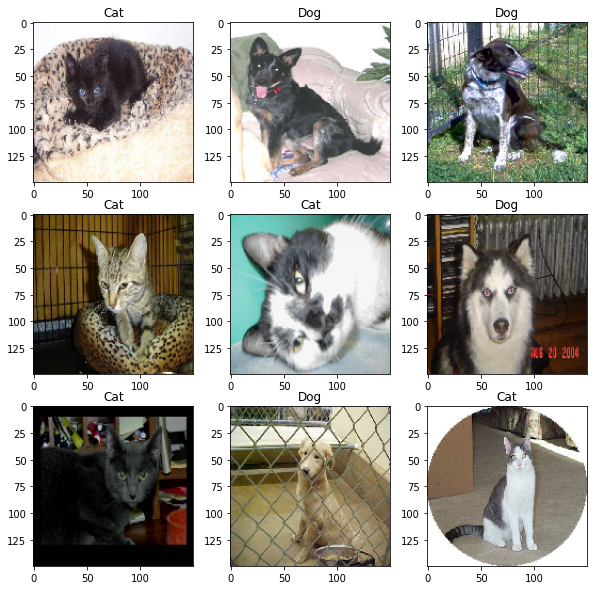

In [339]:
from sklearn.metrics import confusion_matrix
y_true =[]

for file in os.listdir("./testing/test") :
    if file.startswith("cat"):
        y_true.append(0)
    else :
        y_true.append(1)
        
print(confusion_matrix(y_true, y_pred_classification))



test_generator.reset()
test_images = test_generator[0][:9]

fig, ax = plt.subplots(3,3)
fig.set_size_inches(10,10)
for i, img in enumerate(test_images):
    ax[i//3][i%3].imshow(img)
    if y_pred_classification[i]==1:
        label = 'Dog'
    else:
        label = 'Cat'
    ax[i//3][i%3].set_title(label)

Visualizing first 9 filters

In [340]:
model.layers

(150, 150, 64)


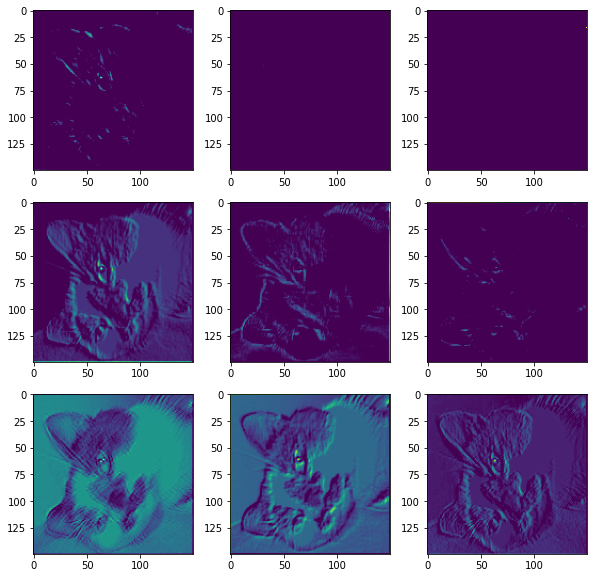

In [341]:
first_conv = model.layers[0]
output_layer1 = first_conv(test_images)[4]

print(output_layer1.shape)
fig, ax = plt.subplots(3,3)
fig.set_size_inches(10,10)
for i in range(9):
  ax[i//3][i%3].imshow(output_layer1[:,:,i])